In [15]:
import os
from collections import defaultdict
import json

In [16]:
metrics_dir = 'metrics'

In [25]:
exp_var_bs = True

In [21]:
# get all files in metrics dir 
metrics_files = [f for f in os.listdir(metrics_dir) if os.path.isfile(os.path.join(metrics_dir, f))]
#group by first part of file name (before the first underscore)
metrics_groups = defaultdict(list)
for f in metrics_files:
    group = f.split('_')[0]
    if group == 'exp':
        # get target batch size
        target_bs = int(f.split('_')[13][3:])
        if exp_var_bs and target_bs == 100:
            continue
        elif not exp_var_bs and target_bs != 100:
            continue
    metrics_groups[group].append(f)
# get mix rate (5th part of file name) and sort by it
for group, files in metrics_groups.items():
    metrics_groups[group] = sorted(files, key=lambda f: float(f.split('_')[4]))

# for each mix rate in each group, load last element in acc_0, acc_1, acc_0_alt, acc_1_alt
# and save them to a dictionary 
metrics = {}
for group, files in metrics_groups.items():
    metrics[group] = {}
    for f in files:
        mix_rate = f.split('_')[4]
        with open(os.path.join(metrics_dir, f)) as file:
            data = json.load(file)
            metrics[group][mix_rate] = {
                'acc_0': data['acc_0'][-1],
                'acc_1': data['acc_1'][-1],
                'acc_0_alt': data['acc_0_alt'][-1],
                'acc_1_alt': data['acc_1_alt'][-1]
            }


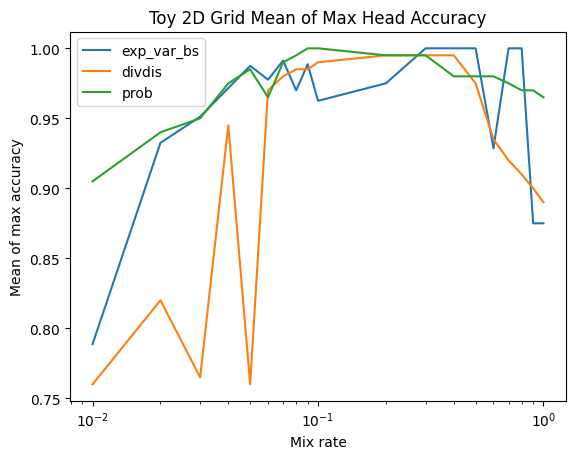

In [27]:
# for each loss function, plot mean of max(acc_0, acc_1) and max(acc_0_alt, acc_1_alt) for each mix rate
import matplotlib.pyplot as plt
import numpy as np

for group, data in metrics.items():
    mix_rates = list(map(float, data.keys()))
    acc_0 = np.array([v['acc_0'] for v in data.values()])
    acc_1 = np.array([v['acc_1'] for v in data.values()])
    acc_0_alt = np.array([v['acc_0_alt'] for v in data.values()])
    acc_1_alt = np.array([v['acc_1_alt'] for v in data.values()])
    mean_acc = np.mean(np.vstack([np.maximum(acc_0, acc_1), np.maximum(acc_0_alt, acc_1_alt)]), axis=0)
    if group == 'exp' and exp_var_bs:
        group = 'exp_var_bs'
    plt.plot(mix_rates, mean_acc, label=group)
plt.xlabel('Mix rate')
plt.ylabel('Mean of max accuracy')
plt.title('Toy 2D Grid Mean of Max Head Accuracy')
plt.xscale('log')
plt.legend()